In [5]:
import numpy as np
import cv2
import os
import random
# from PIL import Image
import time
import matplotlib.pyplot as plt
import math
HEIGHT = 2160
WIDTH = 3840

In [6]:
CENTER = (int(2160/2)+100,1950)
CENTER_CV = (CENTER[1],CENTER[0])

In [7]:
def bounding(mask, pad = 0):
    mask = mask.astype("uint8")* 255
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if contours:
        x_min = 9999
        y_min = 9999
        x_max = 0
        y_max = 0
        for contour in contours:
        # Get the bounding rectangle of the largest contour
            x, y, w, h = cv2.boundingRect(contour)

            # Calculate min and max coordinates
            if x < x_min:
                x_min = x 
            if y < y_min:
                y_min = y
            if (y + h - 1) > y_max:
                y_max = (y + h - 1)
            if (x + w - 1) > x_max:
                x_max = (x + w - 1)

        return {'x_min': max(0,x_min- pad),
                'x_max': min(WIDTH, x_max+pad),
                'y_min': max(0, y_min-pad),
                'y_max': min(HEIGHT,y_max+pad)}
    else:
        raise RuntimeError("No contours found in the mask.")

def cropout(img, mask,):
    mydict = bounding(mask)
    img_ = img.copy()   
    img_[mask != True] =0
    img_ = img_[mydict['y_min']:mydict['y_max'],mydict['x_min']:mydict['x_max']]
    return img_

In [8]:
def calculate_angle(center, point):
    dx = point[0] - center[0]
    dy = point[1] - center[1]
    radians = np.arctan2(dy, dx)
    return radians
def get_point_on_ray(point, distance, direction = "forward"):
    if direction == "forward":
        angle_radians = calculate_angle(CENTER_CV, point)
        # 計算射線方向的單位向量
        direction = (np.cos(angle_radians), np.sin(angle_radians))
        # 尋找射線上距離中心點指定距離的點
        end_point = [point[0] + int(distance * direction[0]), 
                    point[1] + int(distance * direction[1])]
        # # 如果點超出邊界，將其調整為邊界點
        if 0 >= end_point[0]:
            end_point[0] = 0
        elif end_point[0] >= WIDTH:
            end_point[0] = WIDTH
        if 0 >= end_point[1]:
            end_point[1] = 0
        elif end_point[1] >= HEIGHT:
            end_point[1] = HEIGHT
    else:
        # 如果(x軸)靠近畫面中心，直接上下平移，以免導致畫面反而縮小
        if abs(point[0]- CENTER_CV[0]) < 600:
            if point[1] > CENTER_CV[1]:
                y = point[1]+400
            else:
                y = point[1]-100
            if point[0] > CENTER_CV[0]:
                x = point[0]-100
            else:
                x = point[0]+100
            return (x, y)
        angle_radians = calculate_angle(point, CENTER_CV)
        # 計算射線方向的單位向量
        direction = (np.cos(angle_radians), np.sin(angle_radians))
        # 尋找射線上距離中心點指定距離的點
        max_dist = euclidean_distance(point, CENTER_CV)
        distance = min(distance, max_dist-1)
        end_point = [point[0] + int(distance * direction[0]), 
                    point[1] + int(distance * direction[1])]
        # 如果點超出邊界，將其調整為邊界點
        if 0 >= end_point[0]:
            end_point[0] = 0
        elif end_point[0] >= WIDTH:
            end_point[0] = WIDTH
        if 0 >= end_point[1]:
            end_point[1] = 0
        elif end_point[1] >= HEIGHT:
            end_point[1] = HEIGHT    
    return end_point

In [9]:
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def find_intact_points_forward(contour, reference_point = CENTER_CV):
    if (contour['x_min'] <= CENTER_CV[0] <=  contour['x_max']) and (contour['y_min'] <= CENTER_CV[1] <=  contour['y_max']):
        points1 = [(contour['x_min'],contour['y_min']), (contour['x_max'],contour['y_min']), (contour['x_min'],contour['y_max']), (contour['x_max'],contour['y_max'])]
        points2 =[]
        return points1, points2
    points = [(contour['x_min'],contour['y_min']), (contour['x_max'],contour['y_min']), (contour['x_min'],contour['y_max']), (contour['x_max'],contour['y_max'])]
    # Calculate distances from the reference point
    distances = [(point, euclidean_distance(point, reference_point)) for point in points]
    # Sort based on distance
    distances.sort(key=lambda x: x[1])
    return [distances[2][0], distances[3][0]], [distances[0][0], distances[1][0]]

def find_intact_points_backward(contour, reference_point = CENTER_CV, pad = 50):
    # Calculate distances from the reference point
    if (contour['x_min'] <= CENTER_CV[0] <=  contour['x_max']) and (contour['y_min'] <= CENTER_CV[1] <=  contour['y_max']):
        contour= {'x_min': max(0,contour['x_min']- pad),
                'x_max': min(WIDTH, contour['x_max']+pad),
                'y_min': max(0, contour['y_min']-pad),
                'y_max': min(HEIGHT,contour['y_max']+pad)}
        points1 = []
        points2 = [(contour['x_min'],contour['y_min']), (contour['x_max'],contour['y_min']), (contour['x_min'],contour['y_max']), (contour['x_max'],contour['y_max'])]
        return points1, points2
    points = [(contour['x_min'],contour['y_min']), (contour['x_max'],contour['y_min']), (contour['x_min'],contour['y_max']), (contour['x_max'],contour['y_max'])]
    distances = [(point, euclidean_distance(point, reference_point)) for point in points]
    # Sort based on distance
    distances.sort(key=lambda x: x[1])
    intact = [distances[2][0], distances[3][0]]
    move = []
    for point in [distances[0][0], distances[1][0]]:
        if not (0 < point[0] < WIDTH) or not (0 < point[1] < HEIGHT):
            intact.append(point)
        else:
            move.append(point)
    return move, intact


def cal_distance_rate(point, distance_rate=1, max = 500):
    distance = euclidean_distance(CENTER_CV, point)
    if distance < 100:
        return min(math.log2(distance)*10*distance_rate, max)
    else:
        return min(distance*distance_rate, max)
    
def get_ray_points(mask, direction= "forward", distance_rate = 1):
    contour = bounding(mask, pad= 20)
    if direction == "forward":
        points1, points2 = find_intact_points_forward(contour)
    else:
        points1, points2 = find_intact_points_backward(contour)
    
    result = []
    for point in points1:
        distance = cal_distance_rate(point, distance_rate)
        if direction == "forward":
            intersection = get_point_on_ray(point, distance)
        else:
            intersection = get_point_on_ray(point, distance, direction="backward")
        result.append(tuple(map(int, intersection)))    
    for point in points2:
        result.append(tuple(map(int, point)))
    return result

In [10]:
# def pick_diverse_points(points, features, num_points=300):
#     if len(points) <= num_points:
#         return points, features

#     points_pt = np.array([point.pt for point in points])
#     kmeans = KMeans(n_clusters=num_points)
#     kmeans.fit(points_pt)
#     centers = kmeans.cluster_centers_
#     labels = kmeans.labels_
#     selected_points = []
#     selected_features = []
#     for i in range(num_points): 
#         indexs = np.where(labels == i)[0]
#         n = random.randint(0, len(indexs)-1)
#         selected_points.append(points[indexs[n]])
#         selected_features.append(features[indexs[n]])
#     return selected_points, selected_features

In [11]:
def get_distance_rate(frame_diff):
    return (frame_diff+10)/20

def get_x_diff(y, frame_diff):
    return 250*((abs(y - CENTER_CV[1])+1200)/CENTER_CV[1])*frame_diff/16

def get_y_diff(x, frame_diff):
    return 250*((abs(x - CENTER_CV[0])+1500)/CENTER_CV[0])*frame_diff/16


In [12]:
def domask(reference, mask):
    masked_image = np.zeros_like(reference)
    masked_image[mask] = reference[mask]
    return masked_image
    
def ray_mask(img, mask, direction = 'backward', distance_rate=1):
    points = get_ray_points(mask,direction,distance_rate=distance_rate)
    mask2 = np.zeros_like(img)
    hull = cv2.convexHull(np.array(points))
    cv2.fillConvexPoly(mask2, hull, (255, 255, 255))
    masked_image = cv2.bitwise_and(img, mask2)
    return masked_image

In [13]:
def to_000(number):
    return f"000{str(number)}"[-3:]

In [14]:
class Stitcher:
    def __init__(self, target_num ='016' ,frame_diff = 16 , mask = "mask_016.npy"):
        target_num =to_000(target_num)
        self.target = cv2.imread(f"frame/{target_num}.png")
        self.target_num = target_num
        self.frame_diff = frame_diff
        self.reference_nums = [to_000(int(target_num)-frame_diff),to_000(int(target_num)+frame_diff) ]
        self.reference1 = cv2.imread(f"frame/{self.reference_nums[0]}.png")
        self.reference2 = cv2.imread(f"frame/{self.reference_nums[1]}.png")
        self.totalmask = np.load(mask)
        self.labelnum = (self.totalmask.max())
        self.canvas = np.zeros_like(self.target)
        self.warpdict = {}

    def detect_march_findH(self, target_masked, reference_masked, ratio = 0.75):
        # matches = self.orb_match(target_masked, reference_masked)
        # matches, matches_passed = self.check_match(matches)
        # if not matches_passed:
        src_pts, dst_pts, match_count = self.sift_match(target_masked, reference_masked)
        if match_count < 4:
            # self.drawMatches([reference_masked, target_masked], matches)
            print("no enough matched points to find H")
            return None
        else:
            H = self.fitHomoMat(src_pts, dst_pts)
            return H
    def forward_search(self, target_masked, distance_rate):
        reference_masked =ray_mask(self.reference2, self.mask, direction='forward',distance_rate=distance_rate)
        H = self.detect_march_findH(target_masked, reference_masked)
        return H, reference_masked
    def backward_search(self,target_masked, distance_rate):
        reference_masked =ray_mask(self.reference1, self.mask, direction='backward',distance_rate=distance_rate)
        H = self.detect_march_findH(target_masked, reference_masked)
        return H, reference_masked
    def sift_match(self,img1,img2):
        sift = cv2.SIFT_create(400)
        
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)
        
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        
        matches = flann.knnMatch(des1,des2,k=2)
        
        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        return src_pts, dst_pts, len(good)

    def stitch(self, label):
        '''
            Match points and find H and store in dict, label-wise
        '''
        # Step0 - mask
        self.mask =  (self.totalmask == label)
        if self.mask.sum() == 0:
            return
        target_masked =domask(self.target, self.mask)
        distance_rate= get_distance_rate(self.frame_diff)
        self.warpdict[label]= {}
        
        H, reference_masked = self.forward_search(target_masked, distance_rate)
        if isinstance(H, np.ndarray):
            self.warpdict[label]['forward'] = {'available': True,"H":H, 'mask': self.mask, 'reference_num':self.reference_nums[1], 'reference':reference_masked}
        else:
            self.warpdict[label]['forward'] ={'available': False ,"H":H, 'mask': self.mask, 'reference_num':self.reference_nums[1], 'reference':reference_masked}
        H, reference_masked = self.backward_search(target_masked, distance_rate)
        if isinstance(H, np.ndarray):
            self.warpdict[label]['backward'] = {'available': True,"H":H, 'mask': self.mask, 'reference_num':self.reference_nums[0], 'reference':reference_masked}
        else:
            self.warpdict[label]['backward'] ={'available': False ,"H":H, 'mask': self.mask, 'reference_num':self.reference_nums[0], 'reference':reference_masked}
        return self.warpdict[label]
    
    def warp_and_paste(self):
        for label in self.warpdict.keys():
            current_warpdict = self.warpdict[label]
            mask = current_warpdict['backward']['mask']
            warped_imgs = self.warp(current_warpdict)
            if not bool(warped_imgs):
                continue
            warp_img = self.linear_blending(warped_imgs, current_warpdict, mask)
            self.canvas[mask] = warp_img[mask]
        return self.canvas
    
    def cal_alpha(self, H1, H2):
        alpha =0.2
        beta = (1.0 - alpha)
        return alpha, beta
        
    def linear_blending(self, images, warpdict, mask):
        if len(images) == 1:
            return domask(images[0], mask)
        alpha, beta = self.cal_alpha(warpdict['backward']['H'], warpdict['forward']['H'])
        dst = cv2.addWeighted(images[0], alpha, images[1], beta, 0.0)
        return domask(dst, mask)
    def check_match(self, matches, thres = 0.65):
        if len(matches) < 4:
            return matches, False
        """Check if the match points are mostly horizontial. delete matches with crazy y difference"""
        checked_match = []
        n =0
        for p1, p2 in matches:
            x1, y1 = p1
            x2, y2 = p2
            x_diff = get_x_diff(y1, self.frame_diff)
            y_diff = get_y_diff(x1, self.frame_diff)
            # print( (x1, y1), abs(x1-x2), x_diff, abs(y1-y2), y_diff)
            if abs(x1-x2) < x_diff and abs(y1-y2) < y_diff:
                checked_match.append((p1,p2))
                n+=1
        # print("sucess rate: ", n/len(matches))
        if n/len(matches) < thres:
            return checked_match, False
        return checked_match, True

    # def orb_match(self,img1, img2, max_match = 50):
        """do point metch with ORB(fast)"""
        orb = cv2.ORB_create()
        kp1, des1 = orb.detectAndCompute(img1, None) # queryImage
        kp2, des2 = orb.detectAndCompute(img2, None) # trainImage
        if not isinstance(des1, np.ndarray) or not  isinstance(des2, np.ndarray):
            return []
        # calculate the matched points by estimating the distance bwtween descriptors
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)
        print("match points: ", len(matches))
        max_match = min(max_match, len(matches))
        matches = matches[:max_match]
        q_idx = [match.queryIdx for match in matches]
        t_idx = [match.trainIdx for match in matches]
        # use the index to find corresponding keypoints
        src_pts = np.array([kp1[idx].pt for idx in q_idx])
        dst_pts = np.array([kp2[idx].pt for idx in t_idx])
        matches = []
        for i in range(len(dst_pts)):
            matches.append([src_pts[i], dst_pts[i]])
        matches =np.array(matches, dtype = "int")
        return matches
    
    def drawMatches(self, imgs,matches_pos ):
        '''
            Draw the match points img with keypoints and connection line
        '''
        
        # initialize the output visualization image
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        vis = np.zeros((max(hl, hr), wl + wr, 3), dtype="uint8")
        vis[0:hl, 0:wl] = img_left
        vis[0:hr, wl:] = img_right
        
        # Draw the match
        for (img_left_pos, img_right_pos) in matches_pos:
                pos_l = img_left_pos
                pos_r = img_right_pos[0] + wl, img_right_pos[1]
                cv2.circle(vis, pos_l, 3, (0, 0, 255), 1)
                cv2.circle(vis, pos_r, 3, (0, 255, 0), 1)
                cv2.line(vis, pos_l, pos_r, (255, 0, 0), 3)
                
        # return the visualization
        plt.figure(4)
        plt.title("img with matching points")
        plt.imshow(vis[:,:,::-1])
        #cv2.imwrite("Feature matching img/matching.jpg", vis)
        return vis
    
    def fitHomoMat(self, srcPoints, dstPoints):
        '''
            Fit the best homography model with RANSAC algorithm - noBlending、linearBlending、linearBlendingWithConstant
        '''
        H, _ = cv2.findHomography(srcPoints, dstPoints, cv2.RANSAC, 5.0)
        if not isinstance(H, np.ndarray):
            H, _ = cv2.findHomography(srcPoints, dstPoints, method=0)
        return H
    
    def warp(self, warpdict):
        '''
        Return a pair of warped image 
        '''
        b_dict = warpdict['backward']
        f_dict = warpdict['forward']
        result = []
        if b_dict['available']:
            result.append(cv2.warpPerspective(b_dict['reference'], b_dict['H'], ( WIDTH, HEIGHT,)))
        if f_dict['available']:
            result.append(cv2.warpPerspective(f_dict['reference'], f_dict['H'], ( WIDTH, HEIGHT,), flags = cv2.WARP_INVERSE_MAP))
        return result

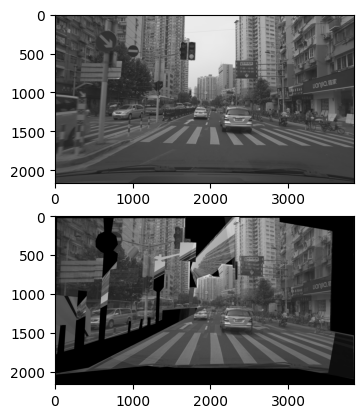

In [15]:
stitcher = Stitcher(target_num ='016' ,frame_diff = 16 , mask = "mask_016.npy")
for i in range(stitcher.labelnum):
    stitcher.stitch(i)
result = stitcher.warp_and_paste()
plt.subplot(211)
plt.imshow(stitcher.target)
plt.subplot(212)
plt.imshow(result)

[[ 1.92160219e-01 -1.16874850e-01  8.87932714e+02]
 [-2.41354558e-01  4.79479354e-01  5.71973521e+02]
 [-1.89981854e-04 -5.46492374e-05  1.00000000e+00]] [[ 8.44537683e-01 -5.66824111e-02  5.89789929e+01]
 [-3.35316563e-02  8.08825026e-01  1.25136739e+02]
 [-3.48414763e-05 -5.97459805e-05  1.00000000e+00]]


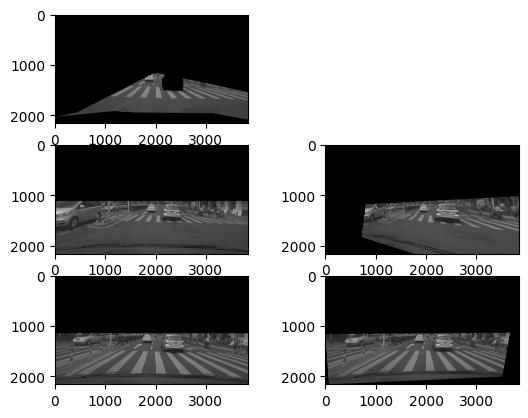

In [16]:
label = 9
print( stitcher.warpdict[label]['backward']['H'], stitcher.warpdict[label]['forward']['H'],)
plt.subplot(321)
plt.imshow(domask(stitcher.target, stitcher.warpdict[label]['backward']['mask']))
plt.subplot(323)
plt.imshow(stitcher.warpdict[label]['backward']['reference'])
plt.subplot(324)
plt.imshow(stitcher.warp(stitcher.warpdict[label])[0])
plt.subplot(325)
plt.imshow(stitcher.warpdict[label]['forward']['reference'])
plt.subplot(326)
plt.imshow(stitcher.warp(stitcher.warpdict[label])[1])
